In [29]:
#Bibliotecas core
import pandas as pd
import numpy as np
import math

#Statsmodel para criação dos modelos de regressão linear e avaliação das métricas
import statsmodels.formula.api as sm
import statsmodels.api         as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

#SKLearn para o split da base, pipeline com transformação das colunas, criação do modelo RandomForest e avaliação do mesmo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

#Bibliotecas para plot
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração para mostrar os diagramas dos pipelines realizados com o SkLearn, apenas para melhorar a visualização de como o modelo está trabalhando.
from sklearn import set_config
set_config(display='diagram')

# DICA organize funções e rotinas que serão reutilizada no começo do seu notebook
# (se necessário essas funções podem ser centralizadas em um arquivo de utilidades -> utilidades.py)

#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figurea
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

    
#Função para calcular o VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')




# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report


In [19]:
#Funções utilizadas posteriormente no código

#FUNÇÃO PARA CALCULAR O VIF
def calc_vif(dataframe):
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

#FUNÇÃO PARA EXIBIR AS MÉTRICAS DO MODELO
def imprimir_metricas (y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'MSE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, mse, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

def log_transform(x):
      return np.log(x+1)

<h2> 1. Leitura e processamento do dataframe </h2>

In [20]:
#A leitura é realizada a partir de uma base trabalhada anteriormente
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')
#df = df.drop(['MES_LAN', 'AGENTE', 'DATA_ENT', 'ZONA'], axis=1)

In [21]:
#Removi colunas que não seriam de nenhum interesse para o modelo (como ID e as "Unnamed") e também colunas de preço. Pensando que os preços devem ser altamente correlacionados, deixar 
#Valores na base não traria uma leitura muito interpretativa

#Base que será utilizada para o split 
df_rf = df.drop(['Unnamed: 0.1', 'Unnamed: 0',
       'RENRESP00', 'ID', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'PC_AT_ATU','ANO_LAN', 'MES_LAN',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'PC_M2_AT_log', 'VLR_US__CO_log', 'PCMEDAU10_log', 'PC_M2_AU_log', 
       'DATA_ENT','PERC_PPI', 'PERC_4_MAIS_MORADORES',
       'Brancos', 'Pretos', 'Amarelos', 'Pardos', 'Índigenas', 'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 moradores','Domicilios 4 ou mais moradores', 'Residentes no setor censitário', 'SC_2010', 'AP2010', 'BANH_DORM', 'Domicílios_Setor',
       'UNIDAND', 'DORM_EMP',  'BLOCOS', 'Média_Moradores_por_domicilio_setor', 'REGIAO', 
       ], axis=1)

df['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df['RENRESP10_log'] = np.log(df['RENRESP10'])

df_rf['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df_rf['RENRESP10_log'] = np.log(df['RENRESP10'])

<h3>1.1 Definindo as variáveis que estarão presentes no modelo</h3>

In [22]:
#Indicação das targets de cada modelo
target_au = 'PC_AU_ATU' #Target: Preço da área útil 
target_tt = 'PC_TT_ATU_log' #Target: Preço total da unidade

#As variáveis numéricas e categóricas que acabam sendo utilizadas posteriormente nos modelos de regressão linear
numericas = ['ANO_LAN', 'DORM_UNID', 'BANH_DORM', 'AR_UT_UNID']
categoricas = ['REGIAO', 'TIPO_EMP', 'AGENTE', 'CONSTRUTOR']
features = numericas + categoricas

#Variáveis que serão utilizadas no modelo de RF
numericas2 = df_rf.select_dtypes(['int', 'float']).columns
numericas2 = numericas2.drop(['PC_AU_ATU', 'PC_TT_ATU', 'PC_AU_ATU_log', 'PC_TT_ATU_log'])
categoricas2 = df_rf.select_dtypes(['object', 'string']).columns

#unidade = ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID', 'PC_TT_ATU']
#df_rf2 = df[unidade]

In [23]:
#Preenchendo as variáveis categóricas com o valor mais frequente, realizando isso para evitar posteriores erros no RF
for col in categoricas2:
    df[col] = df[col].fillna(df[col].mode())

#Realizando label encoder nas variáveis dos modelos de regressão linear
for col in categoricas:
    df[col] = LabelEncoder().fit_transform(df[col].array.reshape(-1, 1))

C:\Users\m2032\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [24]:
'''for col in unidade:
    df_rf2[col] = df_rf2[col].fillna(df_rf2[col].mode())'''

'for col in unidade:\n    df_rf2[col] = df_rf2[col].fillna(df_rf2[col].mode())'

In [25]:
#Train_Test split
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop([target_au, target_tt, 'PC_TT_ATU_log', 'PC_AU_ATU_log'], axis=1), df_rf[target_au], test_size=0.2)
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(df_rf.drop([target_au, target_tt, 'PC_TT_ATU', 'PC_AU_ATU_log'], axis=1), df_rf[target_tt], test_size=0.2)

<h2>2. Interpretando a formulação dos preços dos imóveis - Modelos de regressão linear </h2>

O modelo de regressão linear permite maior interpretabilidade das variáveis e da constituição do preço dos empreendimentos lançados. Contém alguma perda de performance em relação aos modelos mais avançados, como ensembles de Random Forest, mas são mais facilmente lidos.

<h3>2.1 - Criando o baseline</h3>
No modelo baseline foram consideradas variáveis que são intuitivamente conhecidas na descrição de um empreendimento imobiliário, como o número de dormitórios, o número de banheiros e a área do apartamento.

In [28]:
#Criando os modelos baseline do preço da área útil e da área total. A ideia é que os modelos posteriores consigam um R² maior e AIC/BIC menores
tt_baseline = sm.ols(formula='PC_TT_ATU ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()

tt_baseline.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PC_TT_ATU   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                 1.702e+04
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:54:23   Log-Likelihood:            -1.8628e+05
No. Observations:               13548   AIC:                         3.726e+05
Df Residuals:                   13544   BIC:                         3.726e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.031e+04   6712.720     -3.026      0.002   -3.35e+04   -7152.164
DORM_UNID  -1.202e+05   3805.484    -31.580      0.000   -1.28e+05   -1.13e+05
BANH_UNID   8.417e+04   4727.672     17.804      0.000    7.49e+04    9.34e+04
AR_UT_UNID  7686.0010     68.518    112.175      0.000    7551.696    7820.306
==============================================================================
Omnibus:                     1744.701   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8566.921
Skew:                           0.534   Prob(JB):                         0.00
Kurtosis:                       6.746   Cond. No.                         430.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Percebe-se que as variáveis relacionadas apenas ao apartamento não explicam bem, sozinhas, a variação do preço da área útil. O grau de explicabilidade das variáveis se mantém abaixo dos 20% para o caso da variável resposta em forma absoluta e logarítimica. 

O estudo sobre a dinâmica imobiliária no mercado de São Paulo leva ao entendimento de que duas variáveis são cruciais para o entendimento do preço das unidades: O local do empreendimento e o ano de lançamento. O local do empreendimento importa porque uma cidade desigual como São Paulo contém uma alta variabilidade no preço da terra, que se reflete diretamente nos valores de compra e venda de aluguéis dos imóveis; o ano de lançamento mantém relações com a macroeconomia, no sentido de que embora a demanda por moradia sempre seja alta, em anos de boom econômico a oferta e a disponibilidade de renda crescem exponencialmente. 
A seguir, essas duas variáveis são inseridas no modelo da resposta logarítimica do preço da área útil da unidade. 

<h3>2.2 - Otimizando os modelos</h3>

In [12]:
#Variáveis utilizadas em cada um dos modelos
variaveis_tt = ['DORM_UNID','UNIDAND','REGIAO', 'RENRESP10','AR_TT_UNID','GAR_UNID']

#Modelos de regressão da área útil e total da unidade
regressao_tt = sm.ols(formula='PC_TT_ATU_log ~ DORM_UNID + UNIDAND + REGIAO + RENRESP10 + AR_TT_UNID + GAR_UNID', data=df.iloc[X_train.index,:]).fit()            

regressao_tt.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_TT_ATU_log   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     8813.
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:36:07   Log-Likelihood:                -4877.6
No. Observations:               13548   AIC:                             9769.
Df Residuals:                   13541   BIC:                             9822.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5123      0.016    741.293      0.000      11.482      11.543
DORM_UNID      0.0647      0.006     11.756      0.000       0.054       0.076
UNIDAND        0.0201      0.001     13.828      0.000       0.017       0.023
REGIAO        -0.0126      0.001    -11.413      0.000      -0.015      -0.010
RENRESP10      0.0001   1.81e-06     65.378      0.000       0.000       0.000
AR_TT_UNID     0.0038   6.46e-05     58.743      0.000       0.004       0.004
GAR_UNID       0.0922      0.007     13.370      0.000       0.079       0.106
==============================================================================
Omnibus:                       13.112   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.129
Skew:                           0.076   Prob(JB):                      0.00141
Kurtosis:                       3.003   Cond. No.                     2.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>2.3 - Verificando os requisitos de aceitabilidade do modelo</h3>

<h4>2.3.1 Multicolinearidade - Correlação entre variáveis e Variance Inflation Factor</h4>

C:\Users\m2032\AppData\Local\Temp\ipykernel_9028\4064466095.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))


,DORM_UNID,UNIDAND,REGIAO,RENRESP10,AR_TT_UNID,GAR_UNID
DORM_UNID,1.000000,-0.450764,0.033769,0.250199,0.757272,0.733050
UNIDAND,-0.450764,1.000000,0.077963,-0.111127,-0.464656,-0.505392
REGIAO,0.033769,0.077963,1.000000,-0.243812,-0.046012,-0.038359
RENRESP10,0.250199,-0.111127,-0.243812,1.000000,0.503756,0.436574
AR_TT_UNID,0.757272,-0.464656,-0.046012,0.503756,1.000000,0.883877
GAR_UNID,0.733050,-0.505392,-0.038359,0.436574,0.883877,1.000000


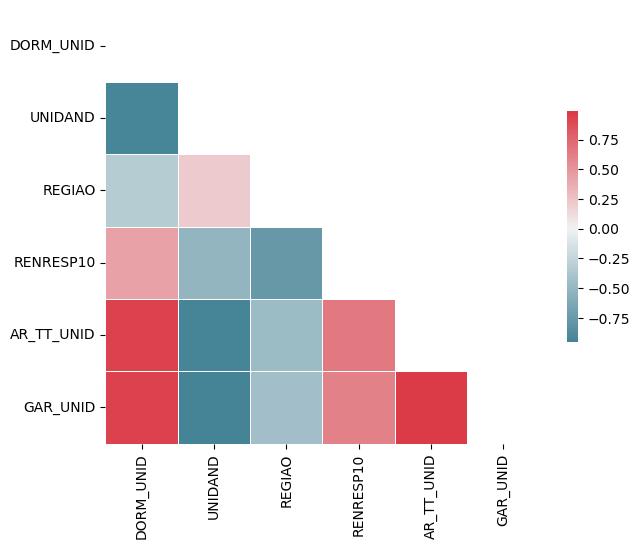

In [24]:
corr_matrix = df[variaveis_tt].corr()
plot_corr_matrix(df[variaveis_tt].corr(), (7, 6))
corr_matrix

In [28]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif_tt = calc_vif(df[variaveis_tt])
#print('vars: ', variaveis_tt)
print('Unidade - Variable Inflation Factors:', vif_tt.VIF.sum(), '\n')




Unidade - Variable Inflation Factors: 70.4215869144956 



<h4>2.3.2 Verificando heteroscedasticidade e normalização/distribuição dos resíduos</h4>

Text(0.51, 0.9, '(VIF - Valor da área útil: 42.94)')

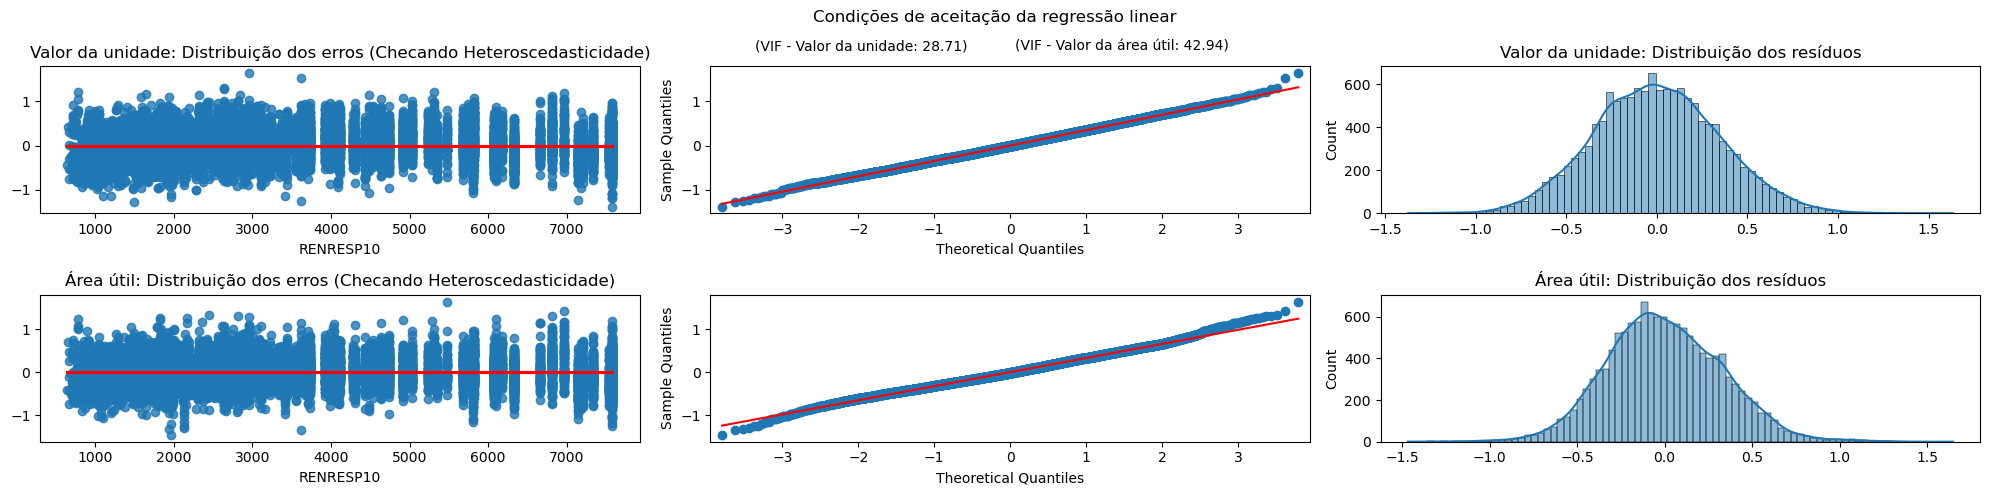

In [ ]:

#Criando os subplots dos testes das regressões
fig, axs = plt.subplots(2, 3, figsize=(20,5), facecolor='white') 
ax00 = sns.regplot(x=X_train.RENRESP10, y=regressao_tt.resid, ax=axs[0,0], line_kws={'color':'red'})
ax01 = sma.qqplot(regressao_tt.resid, line="s", ax=axs[0,1])
ax02 = sns.histplot(regressao_tt.resid, kde=True, ax=axs[0,2])
ax10 = sns.regplot(x=X_train.RENRESP10, y=regressao_au.resid, ax=axs[1,0], line_kws={'color':'red'})
ax11 = sma.qqplot(regressao_au.resid, line="s", ax=axs[1,1])
ax12 = sns.histplot(regressao_au.resid, kde=True, ax=axs[1,2])

#Títulos dos subplots
ax00.set_title('Valor da unidade: Distribuição dos erros (Checando Heteroscedasticidade)')
ax01.suptitle('Valor da unidade: Distribuição dos resíduos (QQPlot)')
ax02.set_title('Valor da unidade: Distribuição dos resíduos')
ax10.set_title('Área útil: Distribuição dos erros (Checando Heteroscedasticidade)')
ax11.suptitle('Área útil: Distribuição dos resíduos (QQPlot)')
ax12.set_title('Área útil: Distribuição dos resíduos')

#Título geral
fig.suptitle('Condições de aceitação da regressão linear')
fig.tight_layout()
fig.text(s='(VIF - Valor da unidade: {})'.format(round(vif_tt.VIF.sum(), 2)), y=0.90, x=0.38)
fig.text(s='(VIF - Valor da área útil: {})'.format(round(vif_au.VIF.sum(), 2)), y=0.90, x=0.51)

<h2>3. Descobrindo os valores de m² e unidade - Modelos de RandomForest </h2>

In [ ]:
#le = LabelEncoder()
#for col in categoricas2:
#    df_rf[col] = le.fit_transform(df_rf[col])

le = LabelEncoder()
for col in X_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist():
    X_train_tt[col] = le.fit_transform(X_train_tt[col])
    X_test_tt[col] = le.fit_transform(X_test_tt[col])
    print(col)

<h4>3.1 - Criação de pipelines para adequação das features e criação do primeiro modelo</h4>

In [ ]:
cat_mask = (X_train_tt.dtypes == 'object').values.flatten()

In [ ]:
#Instanciando os pipelines de tratamento das variáveis do dataframe

#Tratamento categórico: One hot enconding para evitar erros no modelo
#cat_pipeline = Pipeline(steps=[
#    ("input", SimpleImputer(strategy='most_frequent')),
#    ("cat", OrdinalEncoder())
#    ])

#Tratamento numérico: input de dados faltantes e scaler 
num_pipeline = Pipeline(steps=[
    ("input", SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ])

#Column transformar aplicando os pipelines em todas as variáveis indicadas anteriormente
preprocessing = ColumnTransformer(transformers=[
    #('preprocessamento numerico', num_pipeline, numericas2),
    ('preprocessamento numerico', num_pipeline, numericas2)
    #('preprocessamento categorico', cat_pipeline, categoricas2)
])

#Pipeline do modelo de RandomForest aplicando o pré-processamento 
for algorithm in [RandomForestRegressor, SGDRegressor, HistGradientBoostingRegressor]:
        model = Pipeline(steps=[('Preprocessamento', preprocessing),
        ('regressao', algorithm(random_state=42))])
        model.fit(X_train_tt, y_train_tt) #inserir ou remover o _tt
        y_pred = model.predict(X_test_tt) 
        rmse_log = math.sqrt(mean_squared_error(y_test_tt, y_pred))
        #rmse = np.exp(rmse_log)

        print('RMSE ({}): {:.2f}'.format(algorithm.__name__, rmse_log, 2))
        #print('RMSE ({}): {:.2f}'.format(algorithm, round(np.exp(math.sqrt(mean_squared_error(y_test_tt, y_pred))), 2)))


In [ ]:
X_train_tt.columns

In [ ]:
model.fit(X_train_tt, y_train_tt) #Colocar ou retirar _tt dependendo do modelo
y_pred = model.predict(X_test_tt) #Colocar ou retirar _tt dependendo do modelo

baseline_report = imprimir_metricas(y_test_tt, y_pred) #Colocar ou retirar _tt dependendo do modelo
baseline_report

#Baseline - HGRadient Boost:
#'''RMSE	        71220
#	MAE	            43754
#	R^2	            0.98
#	MAPE	        0.09
#	Avg. target	    571528
#	Avg. Prediction	570407'''

<h4>3.2 - Verificando overfitting por meio de validação cruzada</h4>

In [ ]:
#Relizando o cross validation para identificar possível overfitting no modelo
scores = cross_val_score(model, X_train_tt, y_train_tt, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) #Colocar ou retirar o _tt a depender do modelo
print("RMSE: %0.2f (%0.2f%%) (+/- %0.2f)" % (np.sqrt(abs(scores.mean())), ((np.sqrt(abs(scores.mean()))/np.mean(y_pred))*100) ,np.sqrt(scores.std()) * 2))

#'''Valor da unidade:      HGBoost - RMSE: 72282.02 (12.46%) (+/- 30511.45)


<h4>3.3 - Hiperparametrização - selecionando o melhor conjunto de parâmetros para o modelo a partir de Random/Grid Search</h4>

In [ ]:
#Verificando os parâmetros default do RandomForest
print('Parâmetros default: \n')
print(model[1].get_params())

In [ ]:
#Estabelecendo alguns limites para o random_grid trabalhar em cima e fazer uma pré-seleção dos melhores parâmetros

#Número máximo de estimadores
max_iter = [int(x) for x in np.linspace(start=100, stop=1000, num=20)]
#Alpha da regressão de Ridge 
l2_regularization = [int(x) for x in np.linspace(start=0, stop=100, num=20)]
#Profundidade de cada árvore
max_depth = [int(x) for x in np.linspace(1, 100, 10)]
#Amostras até criar nó
#min_samples_split = [2,5,10,20]
#
min_samples_leaf = [5, 10, 20, 40, 100]
#
#subsample=[0.3, 0.5, 1]
#
learning_rate=[float(x) for x in np.linspace(start=0.1, stop=1, num=10)]

random_grid = {'regressao__max_iter': max_iter,
               'regressao__l2_regularization': l2_regularization,
               'regressao__max_depth': max_depth,
               #'regressao__min_samples_split': min_samples_split,
               'regressao__min_samples_leaf': min_samples_leaf,
               #'regressao__subsample': subsample, #Apenas em GBosst
               'regressao__learning_rate': learning_rate #Apenas em GBosst
               #'regressao__bootstrap': bootstrap #Apenas em RF
                }
print(random_grid)

In [ ]:
#Rodando o modelo de pré-seleção dos hiperparâmetros
modeL_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)
modeL_random.fit(X_train_tt, y_train_tt) #Adicionar ou retirar o _tt conforme modelo

In [ ]:
modeL_random.best_params_

#HGboost:
#'''{'regressao__min_samples_leaf': 40,
# 'regressao__max_iter': 715,
# 'regressao__max_depth': 23,
# 'regressao__learning_rate': 0.1,
# 'regressao__l2_regularization': 57}'''

In [ ]:
#FAZENDO O GRID SEARCH

#GRID DA ÁREA ÚTIL
#param_grid = {
#    'regressao__bootstrap': [True],
#    'regressao__max_depth': [20, 30, 40, 50],
#    'regressao__max_features': [0.3, 0.5, 'sqrt'], #Evitei usar 1.0 visto que a documentação do RandomForest aponta que mais aleatoriedade é possível com valores menores
#    'regressao__min_samples_split': [2, 3, 4, 5],
#    'regressao__n_estimators': [60, 70, 80, 90]
#}

#GRID DO PREÇO DA UNIDADE
param_grid = {'regressao__max_iter': [700, 800],
               'regressao__l2_regularization': [int(x) for x in np.linspace(start=55, stop=75, num=3)],
               'regressao__max_depth': [int(x) for x in np.linspace(start=20, stop=40, num=3)],
               #'regressao__min_samples_split': min_samples_split,
               'regressao__min_samples_leaf': [int(x) for x in np.linspace(start=20, stop=40, num=3)],
               #'regressao__subsample': subsample, #Apenas em GBosst
               'regressao__learning_rate': [0.1, 0.05] #Apenas em GBosst
               #'regressao__bootstrap': bootstrap #Apenas em RF
                }


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_tt, y_train_tt) #Retirar ou colocar o _tt dependendo de qual modelo está sendo trabalhado

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_params_

'''Valor da Unidade (RandomForest):
{'regressao__bootstrap': True,
 'regressao__max_depth': 45,
 'regressao__max_features': 0.5,
 'regressao__min_samples_split': 6,
 'regressao__n_estimators': 60}'''

'''Valor do m² de área útil (RandomForest):
 {'regressao__bootstrap': True,
 'regressao__max_depth': 50,
 'regressao__max_features': 0.5,
 'regressao__min_samples_split': 2,
 'regressao__n_estimators': 80}'''

'''Valor do m² de área útil (HistGradientBoost):
 {'regressao__min_samples_leaf': 40,
 'regressao__max_iter': 800,
 'regressao__max_depth': 20,
 'regressao__learning_rate': 0.1,
 'regressao__l2_regularization': 55}'''

In [ ]:
grid_search.best_params_
best_estimator = grid_search.best_estimator_
random_estimator = modeL_random.best_estimator_


<h2>4. Rodando o modelo na base de teste e verificando a performance </h2>

In [ ]:
y_pred = best_estimator.predict(X_test_tt) #Colocar ou retirar _tt dependendo do modelo

baseline_report = imprimir_metricas(y_test_tt, y_pred) #Colocar ou retirar _tt dependendo do modelo
baseline_report

#'''Valor da unidade 
#   MODELO RANDOM FOREST - RMSE: 136164.2, MAE: 79056.85, R²: 0.93, MAPE: 0.15, AVG TARGET: 587082.20, AVG PRED: 582947.40'''
#   MODELO HGRADIENT BOOST - RMSE: 56471,00, MAE: 31451.87, R²: 0.99, MAPE: 0.06, AVG TARGET: 571528.80, AVG PRED: 571413.10'''

#''' Área útil
#    MODELO 2 - RMSE: 1256.84, MAE: 727.08, R²: 0.81, MAPE: 0.13, AVG TARGET: 5519.69, AVG PRED: 5507.74'''

In [ ]:
score_final = cross_val_score(best_estimator, X_train_tt, y_train_tt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) #Colocar ou retirar o _tt a depender do modelo
print("RMSE: %0.2f (%0.2f%%) (+/- %0.2f)" % (np.sqrt(abs(score_final.mean())), ((np.sqrt(abs(score_final.mean()))/np.mean(y_pred))*100) ,np.sqrt(score_final.std()) * 2))

#   MODELO HGRADIENT BOOST - RMSE: 59090.99 (10.34%) (+/- 27568.21)

<h2>5 - Apêndice - Encontrando features desinteressantes</h2>

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()
selected_cols = corr_matrix['PC_TT_ATU'].sort_values(ascending=True)[:20].index.tolist()
selected_cols

In [ ]:
feature_importances = best_estimator[1].feature_importances_

In [ ]:
permutation_result = permutation_importance(best_estimator, X_test, y_test, n_repeats=30) #Alterar _tt conforme modelo

In [ ]:
df_importancia = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

Conjunto 1: 0.65 (RandomF), 0.39 (RegressãoL)
Conjunto IBGE: 0.53 (RandomF), 0.26 (RegressãoL)
Conjunto 1_log: 0.69 (RandomF), 0.40 (RegressãoL)